# Bidirectional LSTM in Keras with GloVe embeddings:

In this quick kernel I'm going to use a multilayered bidirectional LSTM to classify text. Rather than using random embeddings for words I'm going to use GloVe embeddings.
This has the benifit that words which are close to one another are in some sense close in the embedding space.

# Description
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision, but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.
In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not using Bidirectional LSTMs.

# Dataset
News Headlines dataset for Sarcasm Detection

The dataset is collected from two news websites, theonion.com and huffingtonpost.com

This new dataset has the following advantages over the existing Twitter datasets: since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets. Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements.

Content

Each record consists of three attributes:
- is_sarcastic: 1 if the record is sarcastic otherwise 0
- headline: the headline of the news article
- article_link: link to the original news article. Useful in collecting supplementary data

Reference:
https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

Implementation steps:

1. Read and explore the data
2. Drop one column
3. Get length of each sentence
4. Define parameters
5. Get indices for words
6. Create features and labels
7. Get vocab size
8. Create a weight matrix using GloVe embeddings
9. Define and compile a Bidirectional LSTM model
10. Fit the model and check the validation accuracy


# Sarcasm Detection

## Install `Tensorflow2.0` 

In [1]:
!!pip uninstall tensorflow
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 119kB/s 
     |████████████████████████████████| 450kB 62.2MB/s 
     |████████████████████████████████| 3.8MB 35.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=6742d8defd2208f67b1f22524906e9803727297bb616589837ada923ae8975c7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0


#### Get required files from drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#### Change te working directory:

In [0]:
import os
project_path =  'My Drive/Machine Learning/Project 7/'
os.chdir('/content/drive/' + project_path) # Updating the working directory

#### Read Data "Sarcasm_Headlines_Dataset.json". Explore the data and get  some insights about the data.

In [4]:
import pandas as pd
df = pd.read_json (r'./Sarcasm_Headlines_Dataset.json', lines=True)
print('This dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')
df.head()

This dataset has 26709 rows, and 3 columns


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


#### Drop `article_link` from dataset and rename the columns:

In [5]:
df.drop('article_link', axis=1, inplace=True)
df.columns = ['headline','Target']
df.head()

,headline,Target
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


#### Check if the problem is unbalanced:

56.1% of the values in 'Target' are = 0
43.9% of the values in 'Target' are = 1




Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

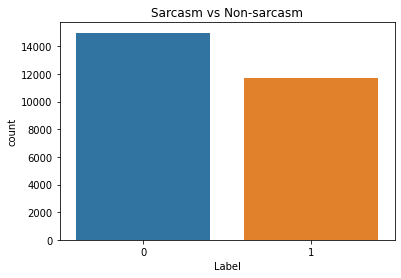

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("{:2.1%} of the values in 'Target' are = 0".format(1-df['Target'].sum()/len(df)))
print("{:2.1%} of the values in 'Target' are = 1\n\n".format(df['Target'].sum()/len(df)))

sns.countplot(df.Target)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

Ideally you should try clean your sentences in exactly the same way that it's been cleaned for the word embeddings. If you don't do this then later when we try to match words up with vectors we won't find a match!

Sadly, I'm not sure how the embeddings used in this data source were used, but this seems fairly close (I've also replaced urls with 'url')

In [0]:
import re

replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

def clean_str(x):
    x = str(x)
    
    x = x.lower()
    
    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)
    
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
        
    for punct in strip_chars:
        x = x.replace(punct, ' ') 
    
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
        
    return x


df['headline'] = df['headline'].apply(clean_str)

#### Get the length of each line and find the maximum length:

In [11]:
lengths = []

for i in range(0,len(df)): 
    length = len(df['headline'][i])
    lengths.append(length)

maxlen = max(lengths)
print("The max length is: {}".format(maxlen))

The max length is: 258


#### Set different parameters for the model:

In [0]:
max_features = 10000 # this is the number of words we care about
maxlen = maxlen
embedding_size = 200

#### Apply Keras Tokenizer of headline column of your data:

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['headline'].values)

#### Define X and y for your model:

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

X = tokenizer.texts_to_sequences(df['headline'].values) # this takes our sentences and replaces each word with an integer
X = pad_sequences(X, maxlen = maxlen) # we then pad the sequences so they're all the same length (sequence_length)
y = pd.get_dummies(df['Target']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # let's keep 10% samples back as a test set

print("Number of Samples:", len(X_train),'\n')
print('See an example below:')
print(X_train[0])
print("\n\nNumber of Labels: ", len(y_train),'\n')
print('See an example below:')
print(y_train[0])

Number of Samples: 24038 

See an example below:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   

#### Get the vocabulary size:

In [15]:
voc_size = tokenizer.word_index
print('The vocabulary size is: %s' % len(voc_size))

The vocabulary size is: 25344


#### Get Glove Word Embeddings:

In [0]:
# Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile("glove.6B.zip", 'r') as z:
  z.extractall()

#### Get the Word Embeddings using Embedding file as given below:

In [0]:
import numpy as np

EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

#### Create a weight matrix for words in training docs:

In [18]:
num_words = min(max_features, len(voc_size)) + 1
embedding_matrix = np.zeros((num_words, embedding_size)) # first create a matrix of zeros, this is our embedding matrix

for word, i in tokenizer.word_index.items(): # for each word in out tokenizer lets try to find that work in our w2v model
    if i > max_features:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None: # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_size) # doesn't exist, assign a random vector

len(embeddings.values())

400000

## Modelling

#### Import required modules required for modelling:

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

#### Create and Compile the Model:

The important bit here is the Embedding, we need to specify the embeddings matrix (the set of vectors representing our words) and for this example I'm going to make them trainable - this means they can be modified during training if something more accurate is found.

I am going to try first a LSTM and then a Bidirectional LSTM:

In [20]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(num_words,
                    embedding_size,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=True))
model_LSTM.add(SpatialDropout1D(0.2))
model_LSTM.add(LSTM(128, return_sequences=True))
model_LSTM.add(LSTM(64))
model_LSTM.add(Dropout(0.25))
model_LSTM.add(Dense(units=2, activation='softmax')) # This code works with 2 or more classes. I could have used sigmoid activation function and bina
model_LSTM.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_LSTM.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 258, 200)          2000200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 258, 200)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 258, 128)          168448    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 2,218,186
Trainable params: 2,218,186
Non-trainable params: 0
______________________________________________

#### Fit the model with a batch size of 100 and validation_split = 0.2. and state the validation accuracy


In [21]:
batch_size = 100
epochs = 5
history_LSTM = model_LSTM.fit(X_train, 
                              y_train, 
                              epochs = epochs, 
                              batch_size = batch_size, 
                              verbose = 1,
                              validation_split=0.2)

Train on 19230 samples, validate on 4808 samples
Epoch 1/5
19230/19230 [==============================] - 293s 15ms/sample - loss: 0.4745 - accuracy: 0.7656 - val_loss: 0.3562 - val_accuracy: 0.8473
Epoch 2/5
19230/19230 [==============================] - 282s 15ms/sample - loss: 0.3101 - accuracy: 0.8698 - val_loss: 0.3177 - val_accuracy: 0.8661
Epoch 3/5
19230/19230 [==============================] - 280s 15ms/sample - loss: 0.2349 - accuracy: 0.9058 - val_loss: 0.3043 - val_accuracy: 0.8729
Epoch 4/5
19230/19230 [==============================] - 279s 15ms/sample - loss: 0.1778 - accuracy: 0.9303 - val_loss: 0.3141 - val_accuracy: 0.8735
Epoch 5/5
19230/19230 [==============================] - 282s 15ms/sample - loss: 0.1314 - accuracy: 0.9500 - val_loss: 0.3632 - val_accuracy: 0.8731


#### Visualizations:

The accuracy for the LSTM is: 87.4%



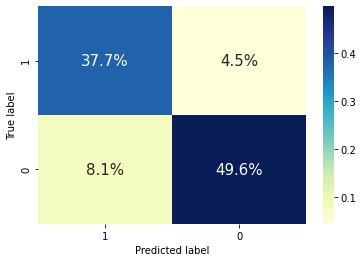

In [22]:
y_pred_LSTM = model_LSTM.predict(X_test)

print("The accuracy for the LSTM is: {:2.1%}\n".format(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_pred_LSTM)))))
cm = metrics.confusion_matrix(list(map(lambda x: np.argmax(x), y_test)),list(map(lambda x: np.argmax(x), y_pred_LSTM)),[1,0])
cm = cm/cm.sum()
sns.heatmap(cm, 
            annot=True,  
            annot_kws={'size': 15},
            fmt='.1%', 
            xticklabels = ["1", "0"], 
            yticklabels = ["1", "0"], 
            linecolor='white',
            cmap='YlGnBu')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

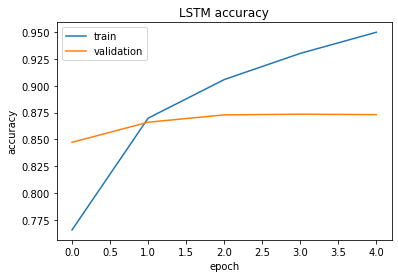

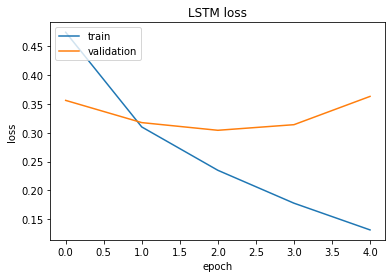

In [23]:
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Now I can try with a Bidirectional LSTM:

In [24]:
model_BLSTM = Sequential()
model_BLSTM.add(Embedding(num_words,
                          embedding_size,
                          embeddings_initializer=Constant(embedding_matrix),
                          input_length=maxlen,
                          trainable=True))
model_BLSTM.add(SpatialDropout1D(0.2))
model_BLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
model_BLSTM.add(Bidirectional(LSTM(64)))
model_BLSTM.add(Dropout(0.25))
model_BLSTM.add(Dense(units=2, activation='softmax')) # This code works with 2 or more classes. I could have used sigmoid activation function and bina
model_BLSTM.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_BLSTM.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 258, 200)          2000200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 258, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 258, 256)          336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,501,706
Trainable params: 2,501,706
Non-trainable params: 0
____________________________________________

In [25]:
batch_size = 100
epochs = 5
history_BLSTM = model_BLSTM.fit(X_train, 
                                y_train, 
                                epochs = epochs, 
                                batch_size = batch_size, 
                                verbose = 1,
                                validation_split=0.2)

Train on 19230 samples, validate on 4808 samples
Epoch 1/5
19230/19230 [==============================] - 643s 33ms/sample - loss: 0.4782 - accuracy: 0.7646 - val_loss: 0.3556 - val_accuracy: 0.8419
Epoch 2/5
19230/19230 [==============================] - 614s 32ms/sample - loss: 0.3032 - accuracy: 0.8730 - val_loss: 0.3176 - val_accuracy: 0.8611
Epoch 3/5
19230/19230 [==============================] - 620s 32ms/sample - loss: 0.2281 - accuracy: 0.9086 - val_loss: 0.3037 - val_accuracy: 0.8706
Epoch 4/5
19230/19230 [==============================] - 620s 32ms/sample - loss: 0.1724 - accuracy: 0.9352 - val_loss: 0.3362 - val_accuracy: 0.8688
Epoch 5/5
19230/19230 [==============================] - 605s 31ms/sample - loss: 0.1295 - accuracy: 0.9515 - val_loss: 0.3715 - val_accuracy: 0.8702


The accuracy for the bidirectional LSTM is: 87.6%



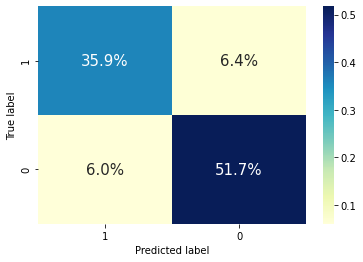

In [26]:
y_pred_BLSTM = model_BLSTM.predict(X_test)

print("The accuracy for the bidirectional LSTM is: {:2.1%}\n".format(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_pred_BLSTM)))))
cm = metrics.confusion_matrix(list(map(lambda x: np.argmax(x), y_test)),list(map(lambda x: np.argmax(x), y_pred_BLSTM)),[1,0])
cm = cm/cm.sum()
sns.heatmap(cm, 
            annot=True,  
            annot_kws={'size': 15},
            fmt='.1%', 
            xticklabels = ["1", "0"], 
            yticklabels = ["1", "0"], 
            linecolor='white',
            cmap='YlGnBu')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Bidirectional LSTM worked sligthly better on the test set. 

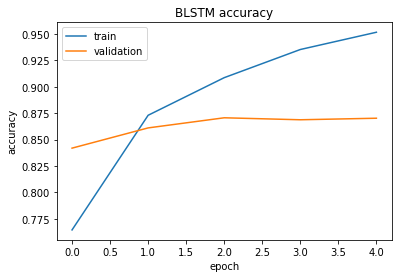

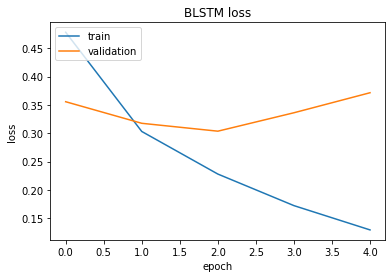

In [27]:
plt.plot(history_BLSTM.history['accuracy'])
plt.plot(history_BLSTM.history['val_accuracy'])
plt.title('BLSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_BLSTM.history['loss'])
plt.plot(history_BLSTM.history['val_loss'])
plt.title('BLSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### I can also compare the 2 losses:

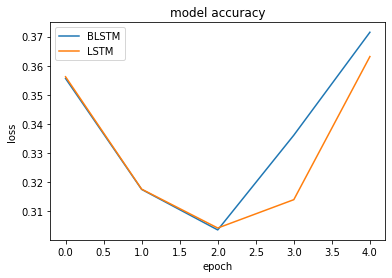

In [28]:
plt.plot(history_BLSTM.history['val_loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['BLSTM', 'LSTM'], loc='upper left')
plt.show()

Both the model had the MIN validation loss after 2 epochs. After that, they startedto overfit. I should retrain the models.

Let's check it's score on sarcastic & non-sarcastic headlines respectively:

In [34]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_test)):
    
    result = model_BLSTM.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 0)[0]
   
    if np.argmax(result) == np.argmax(y_test[x]):
        if np.argmax(y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(y_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("Sarcasm_acc", round(pos_correct/pos_cnt*100,1), "%")
print("Non-Sarcasm_acc", round(neg_correct/neg_cnt*100,1), "%")

Sarcasm_acc 84.9 %
Non-Sarcasm_acc 89.6 %
